In [1]:
import argparse
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import perturbation
from datasets import load_dataset
import utils

/home/byuan48/anaconda3/envs/MIA/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/byuan48/anaconda3/envs/MIA/lib/python3.9/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
tokenizer = AutoTokenizer.from_pretrained("huggyllama/llama-7b")
model = AutoModelForCausalLM.from_pretrained("huggyllama/llama-7b", device_map='auto', torch_dtype=torch.float16)
model.eval()
first_param_device = next(model.parameters()).device

LENGTH = 32
dataset = load_dataset("swj0419/WikiMIA", split=f"WikiMIA_length{LENGTH}")

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.
Loading checkpoint shards: 100%|██████████| 2/2 [00:43<00:00, 21.53s/it]


In [3]:
from rake_nltk import Rake
import re

d = dataset['input'][1]
print(d)
if dataset['label'][1]:
    print("contamination")
else:
    print('no contamination')

r = Rake()
r.extract_keywords_from_text(d)

r.get_ranked_phrases_with_scores()
keywords = r.get_ranked_phrases()
print(keywords)
print((utils.find_word_positions(d,keywords)))

sentence_without_punctuation = re.sub(r'[^\w\s]', '', d)
print(sentence_without_punctuation.lower().split())
len(sentence_without_punctuation.lower().split())





Hurricane Ana was the second tropical cyclone in 2014 to threaten the U.S. state of Hawaii with a direct hit, after Iselle in August. The twenty-first named storm and fifteenth hurricane of
contamination
['second tropical cyclone', 'first named storm', 'hurricane ana', 'fifteenth hurricane', 'direct hit', 'u', 'twenty', 'threaten', 'state', 'iselle', 'hawaii', 'august', '2014']
[1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1.
 0. 1. 1. 1. 0. 1. 1. 0.]
['hurricane', 'ana', 'was', 'the', 'second', 'tropical', 'cyclone', 'in', '2014', 'to', 'threaten', 'the', 'us', 'state', 'of', 'hawaii', 'with', 'a', 'direct', 'hit', 'after', 'iselle', 'in', 'august', 'the', 'twentyfirst', 'named', 'storm', 'and', 'fifteenth', 'hurricane', 'of']


32

In [5]:

def find_token_indices(sentence, keywords, tokenizer):
    # Tokenize the sentence using Hugging Face tokenizer
    tokens = tokenizer.tokenize(sentence)
    
    # Get the offsets (starting index of each token) in the original sentence
    encoded = tokenizer(sentence, return_offsets_mapping=True)
    offset_mapping = encoded['offset_mapping']
    print(encoded)
    print(tokens)
    token_indices = []
    
    # For each keyword, find the corresponding token indices
    for keyword in keywords:
        keyword_start = sentence.lower().find(keyword.lower())  # Find the start index of the keyword
        keyword_end = keyword_start + len(keyword)  # Find the end index of the keyword

        # Find the token indices whose offsets fall within the keyword's range
        indices = [
            i for i, (start, end) in enumerate(offset_mapping) 
            if start >= keyword_start and end <= keyword_end
        ]
        
        token_indices.append(indices)
    
    return token_indices

# Example usage:

sentence = "Machine learning is a method of data analysis that automates analytical model building."
keywords = ["machine learning", "data analysis", "automates"]
indices = find_token_indices(sentence, keywords, tokenizer)
print(indices)


{'input_ids': [1, 6189, 6509, 338, 263, 1158, 310, 848, 7418, 393, 3345, 1078, 16114, 936, 1904, 5214, 29889], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'offset_mapping': [(0, 0), (0, 7), (7, 16), (16, 19), (19, 21), (21, 28), (28, 31), (31, 36), (36, 45), (45, 50), (50, 56), (56, 60), (60, 67), (67, 71), (71, 77), (77, 86), (86, 87)]}
[[0, 1, 2], [8], [11]]


In [9]:
from transformers import LlamaTokenizerFast

# Sentence and keyword positions
sentence = "This is a sample sentence with keywords."
keyword_positions = [5, 6, 7, 15, 16]  # Indices of "a", "sample", and "keywords"

# Tokenize the sentence
tokenizer = LlamaTokenizerFast.from_pretrained('huggyllama/llama-7b')
tokens = tokenizer.encode(sentence)

# Custom function to map character positions to token indices
def char_to_token(sentence, tokenizer):
    char_to_token_map = []
    offset = 0
    for token in tokenizer.encode(sentence).tokens:
        char_to_token_map.extend([len(char_to_token_map)] * len(token))
        offset += len(token)
    return char_to_token_map

# Find important tokens
important_tokens = []
char_to_token_map = char_to_token(sentence, tokenizer)
for char_pos in keyword_positions:
    if char_pos < len(char_to_token_map):
        token_idx = char_to_token_map[char_pos]
        important_tokens.append(tokens[token_idx])

print("Important token IDs:", important_tokens)

AttributeError: 'list' object has no attribute 'tokens'

In [ ]:
d = dataset['input'][2]
re = d.split()[0].lower
' '.join(d.split()[0:2])
print(d)
if dataset['label'][2]:
    print("contamination")
else:
    print('no contamination')
input_ids = tokenizer.encode(d, return_tensors="pt")
input_ids = input_ids.to(model.device)
print(input_ids)
split_words = tokenizer.convert_ids_to_tokens(input_ids[0])
print(split_words)
Entropy = utils.entropy(input_ids, model).cpu().numpy()
plt.figure(figsize=(25, 10))  # Optional: Adjusts the figure size
plt.bar(split_words, Entropy, color='skyblue')  # Creates a bar plot
plt.xticks(rotation=45)
plt.show()


In [ ]:
d = dataset['input'][1]
re = d.split()[0].lower
' '.join(d.split()[0:2])
print(d)
if dataset['label'][1]:
    print("contamination")
else:
    print('no contamination')
input_ids = tokenizer.encode(d, return_tensors="pt")
input_ids = input_ids.to(model.device)
print(input_ids)
split_words = tokenizer.convert_ids_to_tokens(input_ids[0])
print(split_words)
Entropy = utils.entropy(input_ids, model).cpu().numpy()
plt.figure(figsize=(25, 10))  # Optional: Adjusts the figure size
plt.bar(split_words, Entropy, color='skyblue')  # Creates a bar plot
plt.xticks(rotation=45)
plt.show()

In [ ]:
d = dataset['input'][10]
re = d.split()[0].lower
' '.join(d.split()[0:2])
print(d)
if dataset['label'][10]:
    print("contamination")
else:
    print('no contamination')
input_ids = tokenizer.encode(d, return_tensors="pt")
input_ids = input_ids.to(model.device)
print(input_ids)
split_words = tokenizer.convert_ids_to_tokens(input_ids[0])
print(split_words)
Entropy = utils.entropy(input_ids, model).cpu().numpy()
plt.figure(figsize=(25, 10))  # Optional: Adjusts the figure size
plt.bar(split_words, Entropy, color='skyblue')  # Creates a bar plot
plt.xticks(rotation=45)
plt.show()

In [11]:
score_tokens_no = np.zeros(len(tokenizer.vocab))
score_tokens_yes = np.zeros(len(tokenizer.vocab))
times_tokens_no = np.zeros(len(tokenizer.vocab))
times_tokens_yes = np.zeros(len(tokenizer.vocab))

for idx, text in enumerate(dataset['input'], 0):
    input_ids = tokenizer.encode(text, return_tensors="pt")
    input_ids = input_ids.to(model.device)
    if idx % 100 == 0:
        print(f"Processed {idx}/{len(dataset['input'])} texts.")
    Entropy = utils.entropy(input_ids, model).cpu().numpy()
    input_ids = input_ids.cpu().numpy()
    if dataset['label'][idx] == 0:
        score_tokens_no[input_ids[0]] += Entropy
        times_tokens_no[input_ids[0]] += 1
    else:
        score_tokens_yes[input_ids[0]] += Entropy
        times_tokens_yes[input_ids[0]] += 1

Processed 0/776 texts.
Processed 100/776 texts.
Processed 200/776 texts.
Processed 300/776 texts.
Processed 400/776 texts.
Processed 500/776 texts.
Processed 600/776 texts.
Processed 700/776 texts.


[ 4538  9338   628 19811 18210  1682 12625  2765 10513 26844  1988  9272
  4250  2858   593  6451  9133  1579 16540 10901]
[4.73128384e-05 6.22884545e-05 9.21929168e-05 1.07957734e-04
 1.31536508e-04 1.47181563e-04 1.99519112e-04 2.14542102e-04
 2.24840667e-04 2.35201616e-04 2.45629577e-04 2.49999634e-04
 2.50789599e-04 2.58611079e-04 2.78264226e-04 2.96727783e-04
 3.06991511e-04 3.08215880e-04 3.20892461e-04 3.38218233e-04]


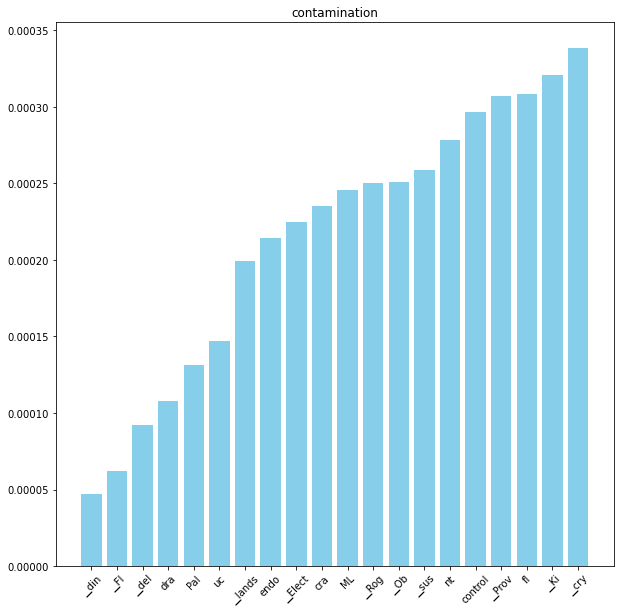

[28224  8598  9338   629  5342 26028   229  4834 21265 13731  2902 10139
 20279  1436 17818  2156   735  3938 13377  6776]
[4.13404559e-05 6.93704933e-05 1.32550573e-04 1.83770680e-04
 2.35832442e-04 2.60203495e-04 2.69385549e-04 3.11491312e-04
 3.19553103e-04 3.31895310e-04 3.35659061e-04 3.51807510e-04
 3.62846360e-04 4.04558086e-04 4.25669714e-04 4.84978256e-04
 4.88672405e-04 5.55679202e-04 5.59613458e-04 5.64859190e-04]


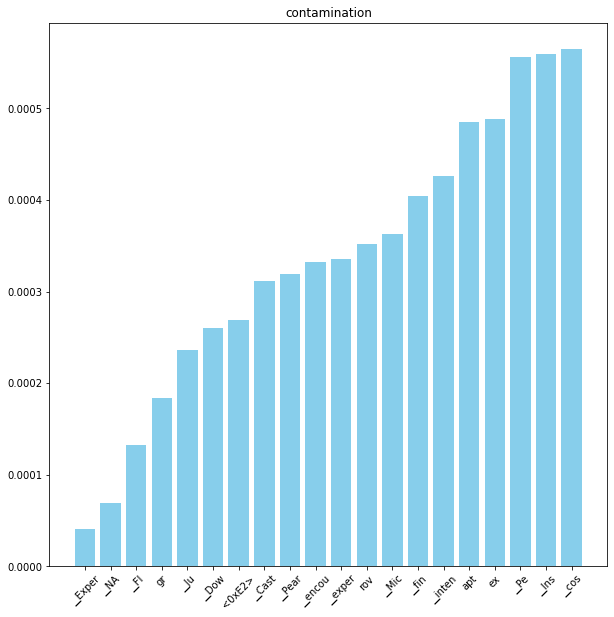

In [12]:
ave_token_yes = np.divide(score_tokens_yes, times_tokens_yes, out=np.zeros_like(score_tokens_yes, dtype=float), where=times_tokens_yes!=0)
ave_token_yes[ave_token_yes == 0] = float('inf')
index = np.argsort(ave_token_yes)[:20]
print(index)
ave = ave_token_yes[index]
print(ave)
words = tokenizer.convert_ids_to_tokens(index)
plt.figure(figsize=(10, 10))  # Optional: Adjusts the figure size
plt.bar(words, ave, color='skyblue')  # Creates a bar plot
plt.xticks(rotation=45)
plt.title('contamination')
plt.show()

ave_token_no = np.divide(score_tokens_no, times_tokens_no, out=np.zeros_like(score_tokens_no, dtype=float), where=times_tokens_no!=0)
ave_token_no[ave_token_no == 0] = float('inf')
index = np.argsort(ave_token_no)[:20]
print(index)
ave = ave_token_no[index]
print(ave)
words = tokenizer.convert_ids_to_tokens(index)
plt.figure(figsize=(10, 10))  # Optional: Adjusts the figure size
plt.bar(words, ave, color='skyblue')  # Creates a bar plot
plt.xticks(rotation=45)
plt.title('contamination')
plt.show()

In [9]:
all_tokens_yes = np.zeros([len(tokenizer.vocab)])
fre_tokens_yes = np.zeros([len(tokenizer.vocab)])
all_tokens_no = np.zeros([len(tokenizer.vocab)])
fre_tokens_no = np.zeros([len(tokenizer.vocab)])
for idx, text in enumerate(dataset['input'], 0):
    input_ids = tokenizer.encode(text, return_tensors="pt")
    input_ids = input_ids.to(model.device)
    if idx % 100 == 0:
        print(f"Processed {idx}/{len(dataset['input'])} texts.")
    Entropy = utils.entropy(input_ids, model).cpu().numpy()
    Entropy[0] = float('inf') # remove the first <s> token, check if needed for other models
    index_min = input_ids[0][np.argmin(Entropy)].cpu()
    index = input_ids[0].cpu()
    if dataset['label'][idx] == 0:
        all_tokens_no[index_min]  = all_tokens_no[index_min]+1
        fre_tokens_no[index] = fre_tokens_no[index] + 1
    else:
        all_tokens_yes[index_min]  = all_tokens_yes[index_min]+1
        fre_tokens_yes[index] = fre_tokens_yes[index] + 1


Processed 0/776 texts.
Processed 100/776 texts.
Processed 200/776 texts.
Processed 300/776 texts.
Processed 400/776 texts.
Processed 500/776 texts.
Processed 600/776 texts.
Processed 700/776 texts.


In [ ]:
# small counts

# all_tokens_no[all_tokens_no == 0] = 1000
# index = np.argsort(all_tokens_no)[:20]
# print(index)
# counts = all_tokens_no[index]
# print(counts)
# words = tokenizer.convert_ids_to_tokens(index)
# plt.figure(figsize=(20, 10))  # Optional: Adjusts the figure size
# plt.bar(words, counts, color='skyblue')  # Creates a bar plot
# plt.xticks(rotation=45)
# plt.show()


387.0
[  383   845   399  8437 27135   369   443   303  2291  9266 29899   350
 29915 27489  3792 29896   279 29871 29900 29906]
[ 2.  2.  2.  2.  2.  2.  2.  3.  3.  3.  3.  3.  3.  3.  3.  4.  5.  8.
 23. 78.]


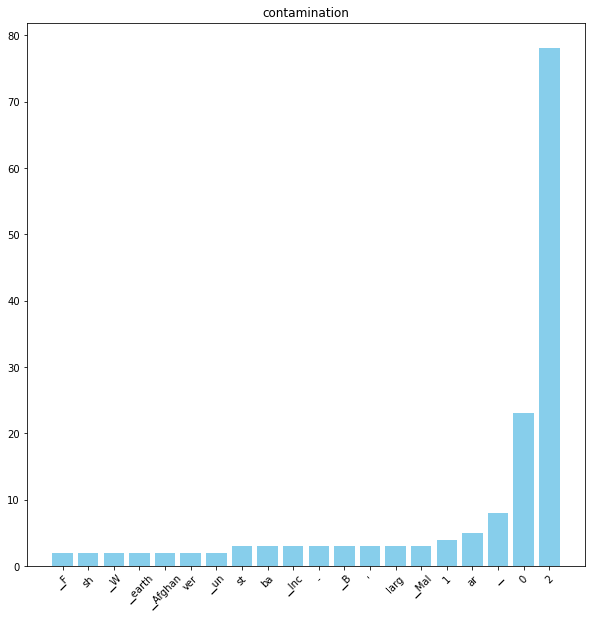

389.0
[29920  5094   279   305  2538 29915   360  3673   283 29899  8383  9266
 29881 22895  5528   380 24613 29871 29896 29906]
[  2.   2.   2.   2.   2.   2.   2.   3.   3.   3.   3.   3.   3.   4.
   4.   5.   7.   7.  10. 104.]


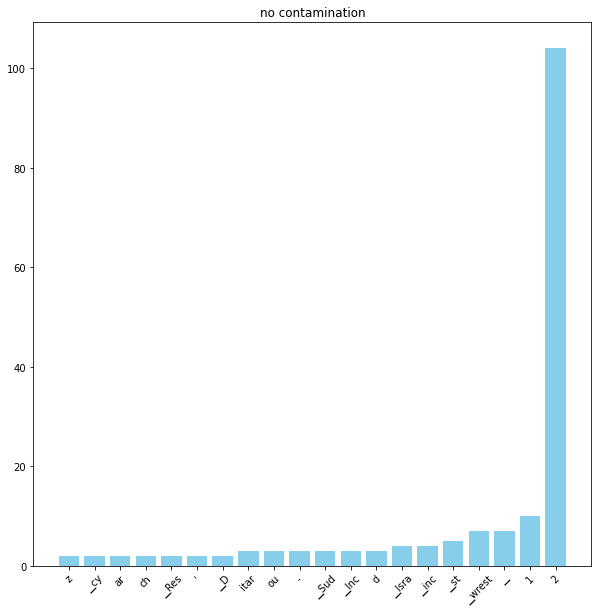

In [10]:
# large counts
index = np.argsort(all_tokens_yes)[-20:]
print(sum(all_tokens_yes))
print(index)
counts = all_tokens_yes[index]
print(counts)
words = tokenizer.convert_ids_to_tokens(index)
plt.figure(figsize=(10, 10))  # Optional: Adjusts the figure size
plt.bar(words, counts, color='skyblue')  # Creates a bar plot
plt.xticks(rotation=45)
plt.title('contamination')
plt.show()

# large counts
index = np.argsort(all_tokens_no)[-20:]
print(sum(all_tokens_no))
print(index)
counts = all_tokens_no[index]
print(counts)
words = tokenizer.convert_ids_to_tokens(index)
plt.figure(figsize=(10, 10))  # Optional: Adjusts the figure size
plt.bar(words, counts, color='skyblue')  # Creates a bar plot
plt.xticks(rotation=45)
plt.title('no contamination')
plt.show()

In [ ]:
# large counts
percent_yes = np.divide(all_tokens_yes, fre_tokens_yes, out=np.zeros_like(all_tokens_yes, dtype=float), where=fre_tokens_yes!=0)
index = np.argsort(percent_yes)[-20:]
print(sum(percent_yes))
print(index)
percent = percent_yes[index]
print(percent)
words = tokenizer.convert_ids_to_tokens(index)
plt.figure(figsize=(10, 10))  # Optional: Adjusts the figure size
plt.bar(words, percent, color='skyblue')  # Creates a bar plot
plt.xticks(rotation=45)
plt.title('contamination')
plt.show()

# large counts
percent_no = np.divide(all_tokens_no, fre_tokens_no, out=np.zeros_like(all_tokens_no, dtype=float), where=fre_tokens_no!=0)
index = np.argsort(percent_no)[-20:]
print(sum(percent_no))
print(index)
percent = percent_no[index]
print(percent)
words = tokenizer.convert_ids_to_tokens(index)
plt.figure(figsize=(10, 10))  # Optional: Adjusts the figure size
plt.bar(words, percent, color='skyblue')  # Creates a bar plot
plt.xticks(rotation=45)
plt.title('contamination')
plt.show()

In [ ]:
tokenizer.convert_ids_to_tokens([29871])

In [ ]:
# unit test for perturb_token_keywords
from rake_nltk import Rake

r = Rake()
r.extract_keywords_from_text(dataset['input'][1])

r.get_ranked_phrases_with_scores()
r.get_ranked_phrases()

from pertubation import perturb_token_keywords
print(len(perturb_token_keywords(dataset['input'][1], 1)))
print(len(dataset['input'][1]))
print(perturb_token_keywords(dataset['input'][1], 1))
print(dataset['input'][1])